In [4]:
import h5py    
import numpy as np
#import torch.nn as nn
#import torch
#from sklearn.preprocessing import LabelEncoder
#from sklearn.model_selection import train_test_split
import os
import pyproj
import geos
from mpl_toolkits.basemap import Basemap

In [5]:
f = h5py.File("/Users/apple-pc/Desktop/courses/COMPSCI 760/research/dataset.hdf5", "r") # Read in the dataset
d = f[list(f.keys())[0]]                                        # Access the thermal videos key

In [6]:
def get_best_index(vid):
    """
    Returns an index such that the selected 45 frames from a given video correspond to
    the 45 frames where the animal is nearest to the camera.
    """
    mass = np.zeros(vid.attrs['frames'])
    for f in range(vid.attrs['frames']):
        mass[f] = np.sum(vid[str(f)][4])
    total_mass_over_next_45 = np.cumsum(mass) - np.hstack([np.zeros(45), np.cumsum(mass[:-45])])
    return f - np.argmax(total_mass_over_next_45[::-1]) - 44    

In [7]:
tag_list = []
device_list = []
fps_list = []
location_list = []
frames_list = []
start_time = []
best_mass = {}
for i in range(len(d.keys())):
    x = d[list(d.keys())[i]]
    device_list.append(x.attrs['device'])
    fps_list.append(x.attrs['frames_per_second'])
    if d[list(d.keys())[i]].attrs.__contains__('location'):
        location_list.append(x.attrs['location'])
    else:
        location_list.append('missing')
    for j in range(len(x.keys()) - 1):
        vid = x[list(x.keys())[j]]
        #tag = vid.attrs['tag']
        tag_list.append(vid.attrs['tag'])
        frames_list.append(vid.attrs['frames'])
        if x[list(x.keys())[j]].attrs.__contains__('start_time'):
            start_time.append(vid.attrs['start_time'])
        else:
            start_time.append('missing')
        if vid.attrs['frames'] >= 45 and not vid.attrs['tag'] in ["unknown", "part", "poor tracking", "sealion"]:
            ind = get_best_index(vid)
            mass = np.zeros(45)
            for f in range(45):
                mass[f] = np.sum(vid[str(f+ind)][4])
            if not vid.attrs['tag'] in best_mass:
                best_mass[vid.attrs['tag']] = [mass[np.argmax(mass)]]
            else:
                best_mass[vid.attrs['tag']].append(mass[np.argmax(mass)])

In [8]:
# get mean frames
np.mean(frames_list)

151.6625929518267

In [9]:
medians = []
for key, value in best_mass.items():
    temp = [key,np.median(value)]
    medians.append(temp)
    
location_list = list(filter(lambda a: a != 'missing', location_list))

from collections import Counter
locations = dict(Counter(map(tuple,location_list)))

counts_tag = dict()
for i in tag_list:
    counts_tag[i] = counts_tag.get(i, 0) + 1

counts_device = dict()
for i in device_list:
    counts_device[i] = counts_device.get(i, 0) + 1
    
counts_fps = dict()
for i in fps_list:
    counts_fps[i] = counts_fps.get(i, 0) + 1

counts_frames = dict()
for i in frames_list:
    counts_frames[i] = counts_frames.get(i, 0) + 1

counts_start = dict()
for i in start_time:
    counts_start[i] = counts_start.get(i, 0) + 1

# {k: v for k, v in sorted(counts_tag.items(), key=lambda item: item[1])}

# {k: v for k, v in sorted(counts_device.items(), key=lambda item: item[1])}

# {k: v for k, v in sorted(counts_fps.items(), key=lambda item: item[1])}

# {k: v for k, v in sorted(counts_frames.items(), key=lambda item: item[1])}

# {k: v for k, v in sorted(counts_start.items(), key=lambda item: item[1])}


In [10]:
# plot frames histogram with cut-off in red            
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fig, ax = plt.subplots(facecolor='white', figsize = (10,6))
plt.hist(frames_list, bins = 200, range = (0,1000), color = "#00008b")
plt.axvline(x=44, color = 'red')
plt.xlabel('Frames')
plt.ylabel('Count')
plt.title('')
plt.savefig("./Frames.png")
plt.show()

<Figure size 1000x600 with 1 Axes>

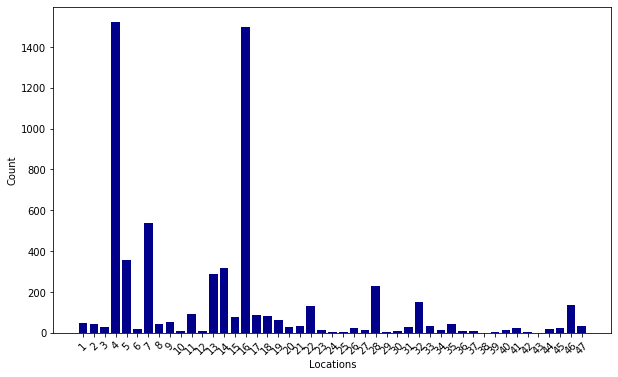

In [11]:
fig, ax = plt.subplots(facecolor='white', figsize = (10,6))
x = np.array(range(1, len(locations.keys())+1))
h = tuple(locations.values())
plt.bar(x, h, width= 0.8, color="#00008b")
plt.xlabel('Locations')
plt.ylabel('Count')
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xticks(x, x, rotation=45, fontsize=10)
plt.title('')
plt.savefig("./Location.png")
plt.show()

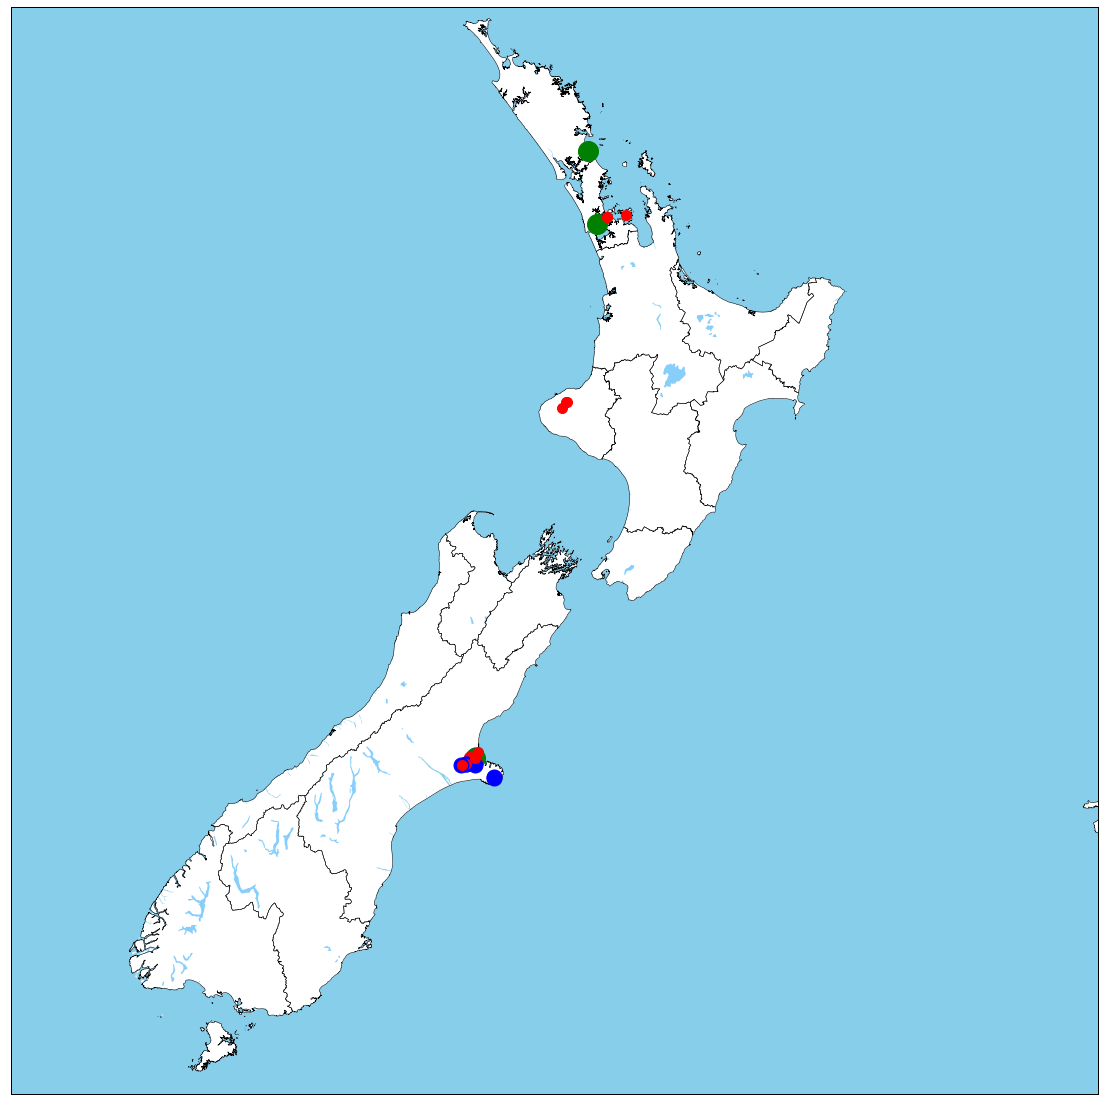

In [18]:
plt.figure(figsize=(20,20))
map = Basemap(projection = 'aeqd', lat_0=-41, lon_0=174, width = 1500000, height = 1500000., resolution="f")
map.readshapefile("gadm36_NZL_shp/gadm36_NZL_1", "NZ", drawbounds=True)
map.fillcontinents(color='white', lake_color='lightskyblue')
map.drawmapboundary(fill_color='skyblue')
for i in range(len(locations.keys())):
    x, y =  map(tuple(locations.keys())[i][1], tuple(locations.keys())[i][0])
    if tuple(locations.values())[i] < 100:
        p1 = map.plot(x, y, marker = '.', color = 'red', markersize = 20)
    elif tuple(locations.values())[i] > 100 and tuple(locations.values())[i] < 500:
        p2 =  map.plot(x, y, marker = '.', color = 'blue', markersize = 30)
    elif tuple(locations.values())[i] > 500:
        p3 = map.plot(x, y, marker = '.', color = 'green', markersize = 40)

plt.savefig("./map.png")
plt.show()